In [29]:
import pickle
from collections import defaultdict
import sklearn as sk
import pandas as pd
pd.options.display.max_colwidth = 1500
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import svm
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from datetime import datetime
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import string
import datetime
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import csv
import json
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



## Data Loading

In [7]:
word_dict=dict()
word_dict['<PAD>'] = 10

In [2]:
csv_file_text = '/Users/bidishadasbaksi/Docs_no_icloud/Documents – Bidisha’s MacBook Pro/ Personal_docs Intuit Laptop/USC Journey/Spring 2022/CSCI-535 Multimodal/Project/segmented/textual_feature_set_new.csv'


In [3]:
df = pd.read_csv(csv_file_text,header=None)
df = df[(df[50]== 'D') | (df[50]== 'Ah') | (df[50]== 'Ih') | (df[50]== 'Z') | (df[50]== 'W') | (df[50]== '0')  ]
unique_classes = df[50].unique().tolist()
unique_classes.remove('0')
indexes = [i for i in range(len(unique_classes))]
replace_dict = {unique_classes[i]:i for i in indexes}
replace_dict['0']=len(unique_classes)
df[[50]] = df[[50]].replace(replace_dict)
                                                              
                                                              

In [4]:
replace_dict

{'Ah': 0, 'Ih': 1, 'Z': 2, 'D': 3, 'W': 4, '0': 5}

In [5]:
df_list  = df.values.tolist()
df_list_n_x = list()
df_l_sub_x=list()
df_list_n_y = list()
df_l_sub_y=list()
for i in df_list:
    if(i[0]!=0):
        l = i[1:len(i)-1]
        l.insert(0,float(i[0]))
        df_l_sub_x.append(l)
        df_l_sub_y.append(i[len(i)-1])
    else:
        if(len(df_l_sub_x)>0):
            df_list_n_x.append(df_l_sub_x)
            df_list_n_y.append(df_l_sub_y)
        df_l_sub_x=list()
        df_l_sub_y=list()

## Train Test Split

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(df_list_n_x, df_list_n_y, test_size=0.33, random_state=12)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=123)





## Data Loader

In [8]:
class Dataset(Dataset):
    def __init__(self, data,label):
        'Initialization'
        dim_size = len(data[0][0])
        data_lengths= [len(frame) for frame in data]
        data_lengths_copy = [len(frame) for frame in data]
        data_lengths_copy.sort()
        pad_token = word_dict['<PAD>']
        longest_frame = data_lengths_copy[-2]
        b_s = len(data_lengths)
        padded_X = np.ones((b_s, longest_frame,dim_size)) * pad_token
        padded_Y = np.ones((b_s,longest_frame)) * pad_token

        print(padded_X.shape)
        for i, d_len in enumerate(data_lengths):
            sequence = data[i]
            sequence_y = label[i]
            if(d_len>longest_frame):
                continue
            
            padded_X[i, (longest_frame-d_len):] = sequence[:longest_frame]
            padded_Y[i,(longest_frame-d_len):] = sequence_y[:longest_frame]
        self.data = torch.Tensor(padded_X)
        self.label = torch.LongTensor(padded_Y)
        self.original_data = data
        self.original_label = label
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        X= self.data[index]
        y = self.label[index]
        return (X, y)

In [9]:
train_data = Dataset( X_train,Y_train)
val_data = Dataset(X_val,Y_val)
test_data = Dataset(X_test,Y_test)

(1796, 125, 50)
(599, 95, 50)
(1181, 112, 50)


In [10]:
num_train = len(X_train)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)



num_dev = len(X_val)
indices_dev = list(range(num_dev))
np.random.shuffle(indices_dev)

train_sampler = SubsetRandomSampler(indices_train)
dev_sampler = SubsetRandomSampler(indices_dev)

batch_size=1

train_loader= torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=0,)
dev_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
    sampler=dev_sampler, num_workers=0)


dev_loader_without_sampler = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=0)


test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=0)


In [11]:
test_loader_one = torch.utils.data.DataLoader( test_data, batch_size=1, num_workers=0)


## GRU Training

In [13]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [14]:
class GRUNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(GRUNet, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.rnn(x, hidden)
        tag_space = self.fc(out)
        tag_scores = F.log_softmax(tag_space, dim=2)
        return tag_scores.view(batch_size*len(x[0]),-1)
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [19]:
new_model = GRUNet(50,6,20,1)
new_model.load_state_dict(torch.load('grunet.pt'))

<All keys matched successfully>

In [16]:
loss_function_glove = nn.CrossEntropyLoss(ignore_index=word_dict['<PAD>'])
optimizer_glove = optim.SGD(new_model.parameters(), lr= 0.01 )
scheduler_glove = optim.lr_scheduler.ReduceLROnPlateau(optimizer_glove,  mode='min',patience=3,factor=0.9)


In [17]:
# best_valid_loss = float(100)

In [18]:
def train_rnn(new_model,best_valid_loss):
    for epoch in range(100):  
        train_loss = 0.0
        valid_loss = 0.0
        new_model.train()
        for dataset, target in train_loader:
            new_model.zero_grad()
            tag_scores = new_model(dataset)
            target = target.view(target.shape[0]*len(dataset[0]))
            loss = loss_function_glove(tag_scores,target)
            loss.backward()
            optimizer_glove.step()
            train_loss += loss.item()*dataset.size(0)
        new_model.eval() 
        with torch.no_grad():
            for dataset, target in dev_loader:
                tag_scores = new_model(dataset)
                target = target.view(target.shape[0]*len(dataset[0]))
                loss = loss_function_glove(tag_scores,target)
                valid_loss += loss.item()*dataset.size(0)
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(dev_loader.dataset)
        print('Time: {} \tEpoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                    datetime.datetime.now(),
                    epoch+1, 
                    train_loss,
                    valid_loss
                    ))
        if(valid_loss < best_valid_loss):
            best_valid_loss = valid_loss
            torch.save(new_model.state_dict(), 'grunet.pt')
        scheduler_glove.step(valid_loss)
    return best_valid_loss

In [547]:
best_valid_loss = train_rnn(new_model,best_valid_loss)

Time: 2022-04-25 22:50:51.792861 	Epoch: 1 	Training Loss: 0.910483 	Validation Loss: 0.955981
Time: 2022-04-25 22:51:25.206898 	Epoch: 2 	Training Loss: 0.910531 	Validation Loss: 0.955978
Time: 2022-04-25 22:51:59.669830 	Epoch: 3 	Training Loss: 0.910719 	Validation Loss: 0.954899
Time: 2022-04-25 22:52:33.681026 	Epoch: 4 	Training Loss: 0.910595 	Validation Loss: 0.954657
Time: 2022-04-25 22:53:06.368374 	Epoch: 5 	Training Loss: 0.910174 	Validation Loss: 0.954576
Time: 2022-04-25 22:53:38.808165 	Epoch: 6 	Training Loss: 0.910339 	Validation Loss: 0.956183
Time: 2022-04-25 22:54:11.190672 	Epoch: 7 	Training Loss: 0.910339 	Validation Loss: 0.954353
Time: 2022-04-25 22:54:47.688741 	Epoch: 8 	Training Loss: 0.909898 	Validation Loss: 0.957591
Time: 2022-04-25 22:55:24.856587 	Epoch: 9 	Training Loss: 0.910248 	Validation Loss: 0.955783
Time: 2022-04-25 22:56:00.293555 	Epoch: 10 	Training Loss: 0.910233 	Validation Loss: 0.956063
Time: 2022-04-25 22:56:34.723297 	Epoch: 11 	Trai

Time: 2022-04-25 23:34:26.696432 	Epoch: 87 	Training Loss: 0.907347 	Validation Loss: 0.952765
Time: 2022-04-25 23:34:53.848284 	Epoch: 88 	Training Loss: 0.907387 	Validation Loss: 0.952952
Time: 2022-04-25 23:35:20.762100 	Epoch: 89 	Training Loss: 0.907383 	Validation Loss: 0.953355
Time: 2022-04-25 23:35:47.906933 	Epoch: 90 	Training Loss: 0.907372 	Validation Loss: 0.953475
Time: 2022-04-25 23:36:14.845813 	Epoch: 91 	Training Loss: 0.907417 	Validation Loss: 0.953190
Time: 2022-04-25 23:36:42.152063 	Epoch: 92 	Training Loss: 0.907303 	Validation Loss: 0.952828
Time: 2022-04-25 23:37:09.043938 	Epoch: 93 	Training Loss: 0.907291 	Validation Loss: 0.952649
Time: 2022-04-25 23:37:37.531171 	Epoch: 94 	Training Loss: 0.907263 	Validation Loss: 0.953011
Time: 2022-04-25 23:38:04.708501 	Epoch: 95 	Training Loss: 0.907269 	Validation Loss: 0.952573
Time: 2022-04-25 23:38:31.830804 	Epoch: 96 	Training Loss: 0.907299 	Validation Loss: 0.953001
Time: 2022-04-25 23:38:58.776957 	Epoch:

## Test Set Prediction and Performance Metrices

In [20]:
def predict(model, dataloader):
    prediction_list = []
    test_data_list = []
    for data, target in dataloader:
        outputs = model(data)
        for i,dat in enumerate(outputs.data):
            predicted = torch.argmax(dat)
            if(target[0][i]!=torch.tensor(word_dict['<PAD>']) ):
                prediction_list.append(predicted)
                test_data_list.append(target[0][i])
    return (test_data_list,prediction_list)

In [21]:
predictions = predict(new_model,test_loader_one)

In [22]:
pred = np.array(predictions[1])
targ = np.array(predictions[0])


### Accuracy

In [23]:
metrics.accuracy_score(targ, pred)


0.603079620383428

### F1 score

In [24]:
metrics.f1_score(targ, pred,average='weighted')


0.5863838629875401

### Confusion Matrix

In [28]:
metrics.confusion_matrix(targ, pred)

array([[3540,  443,   75, 1792,  317],
       [ 533, 2709,   48, 2430,   60],
       [ 417,  207,  794, 1410,   21],
       [ 656,  322,   48, 7595,   42],
       [ 541,  276,   34,  742, 1185]])

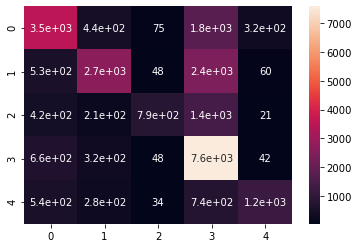

In [30]:
conf = metrics.confusion_matrix(targ, pred)
df = pd.DataFrame(conf, range(5), range(5))
sns.heatmap(df, annot=True)
plt.show()

In [31]:
def calculate_acc_per_class(confusion_matrix):
    classes_ = []
    f1_score = []
    for class_ in range(5):
        classes_k = {}
        fp = 0
        fn = 0
        tn = 0
        for i in range(len(confusion_matrix)):
            for j in range(len(confusion_matrix[i])):
                if (i == j) and (i==class_):
                    classes_k['tp'] = confusion_matrix[i][j]
                elif (i == class_):
                    fp += confusion_matrix[i][j]
                elif (j == class_):
                    fn += confusion_matrix[i][j]
                else:
                    tn += confusion_matrix[i][j]
        classes_k['tn'] = tn
        classes_k['fp'] = fp
        classes_k['fn'] = fn
        classes_k['precision'] = classes_k['tp']/(classes_k['tp'] + fp)
        classes_k['recall'] = classes_k['tp']/(classes_k['tp'] + fn)
        classes_k['f1_score'] =(2* classes_k['precision']  * classes_k['recall']) /(classes_k['precision']  + classes_k['recall'] )
        f1_score.append(classes_k['f1_score'])
        classes_.append(classes_k) 
    f1_score_macro = sum(f1_score)/len(f1_score)
    return classes_, f1_score_macro

In [32]:
res = calculate_acc_per_class(conf)

In [33]:
res

([{'tp': 3540,
   'tn': 17923,
   'fp': 2627,
   'fn': 2147,
   'precision': 0.5740230257823902,
   'recall': 0.6224723052576051,
   'f1_score': 0.5972667454023959},
  {'tp': 2709,
   'tn': 19209,
   'fp': 3071,
   'fn': 1248,
   'precision': 0.46868512110726646,
   'recall': 0.6846095526914329,
   'f1_score': 0.5564342199856219},
  {'tp': 794,
   'tn': 23183,
   'fp': 2055,
   'fn': 205,
   'precision': 0.2786942786942787,
   'recall': 0.7947947947947948,
   'f1_score': 0.41268191268191273},
  {'tp': 7595,
   'tn': 11200,
   'fp': 1068,
   'fn': 6374,
   'precision': 0.8767170726076416,
   'recall': 0.5437039158135872,
   'f1_score': 0.6711735595616826},
  {'tp': 1185,
   'tn': 23019,
   'fp': 1593,
   'fn': 440,
   'precision': 0.4265658747300216,
   'recall': 0.7292307692307692,
   'f1_score': 0.5382693617987735}],
 0.5551651598860774)